<a href="https://colab.research.google.com/github/rahelsmnjtkk/Skripsii/blob/main/Copy_of_HASIL_SKRIPSI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mplfinance
!pip install keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.6 MB/s eta 0:00:00


In [2]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns

In [11]:
df = pd.read_csv('/content/dataset_skripsi.csv')
df

,Date,Close,High,Low,Open,Volume
0,2022-01-03,6820.131836,6889.962537,6796.854935,6820.131836,54287400
1,2022-01-04,6889.962891,6936.516694,6820.132186,6820.132186,70624000
2,2022-01-05,6936.516602,7006.347306,6866.685898,6936.516602,76164900
3,2022-01-06,6959.792969,7006.346768,6913.239170,6983.069868,63657100
4,2022-01-07,7122.731934,7169.285737,6983.070523,7029.624327,143433300
...,...,...,...,...,...,...
717,2024-12-20,9650.000000,9750.000000,9625.000000,9650.000000,91576900
718,2024-12-23,9775.000000,9850.000000,9700.000000,9700.000000,43292100
719,2024-12-24,9750.000000,9900.000000,9750.000000,9850.000000,32415700
720,2024-12-27,9800.000000,9825.000000,9725.000000,9800.000000,24016700


In [12]:
print("Informasi Data : ")
print(df.info())
print(df.head())

Informasi Data : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 722 entries, 0 to 721
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    722 non-null    object 
 1   Close   722 non-null    float64
 2   High    722 non-null    float64
 3   Low     722 non-null    float64
 4   Open    722 non-null    float64
 5   Volume  722 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 34.0+ KB
None
         Date        Close         High          Low         Open     Volume
0  2022-01-03  6820.131836  6889.962537  6796.854935  6820.131836   54287400
1  2022-01-04  6889.962891  6936.516694  6820.132186  6820.132186   70624000
2  2022-01-05  6936.516602  7006.347306  6866.685898  6936.516602   76164900
3  2022-01-06  6959.792969  7006.346768  6913.239170  6983.069868   63657100
4  2022-01-07  7122.731934  7169.285737  6983.070523  7029.624327  143433300


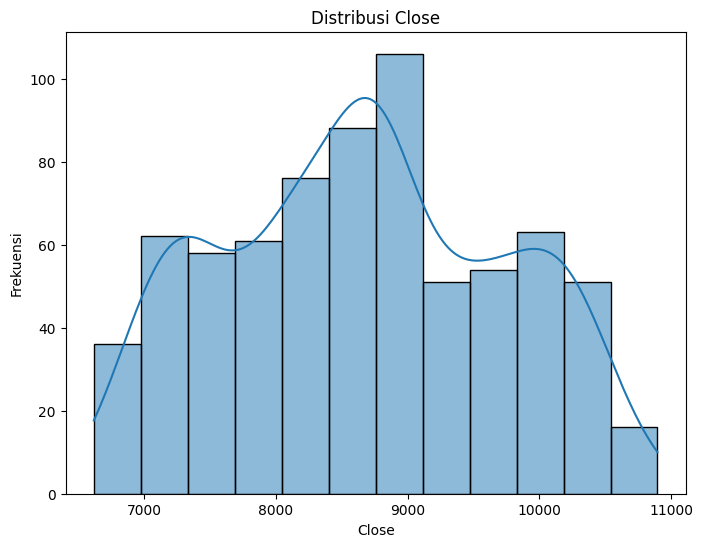

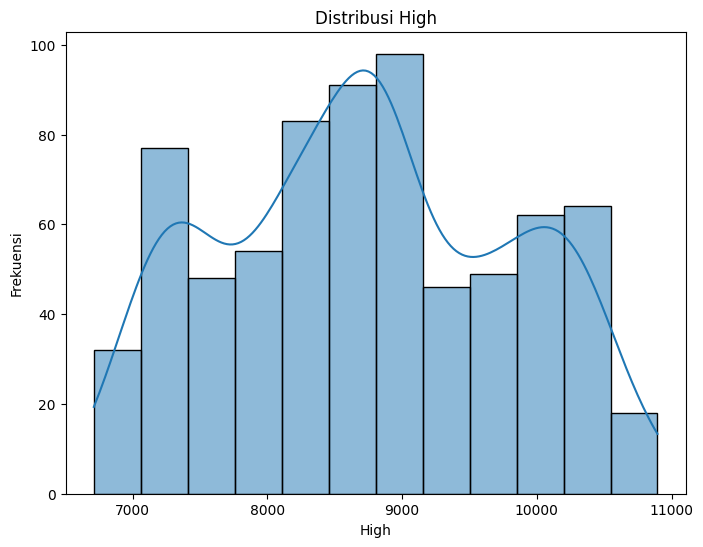

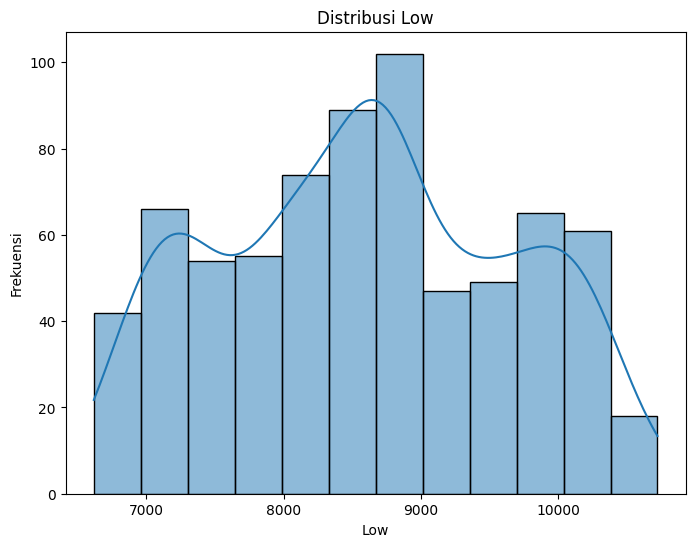

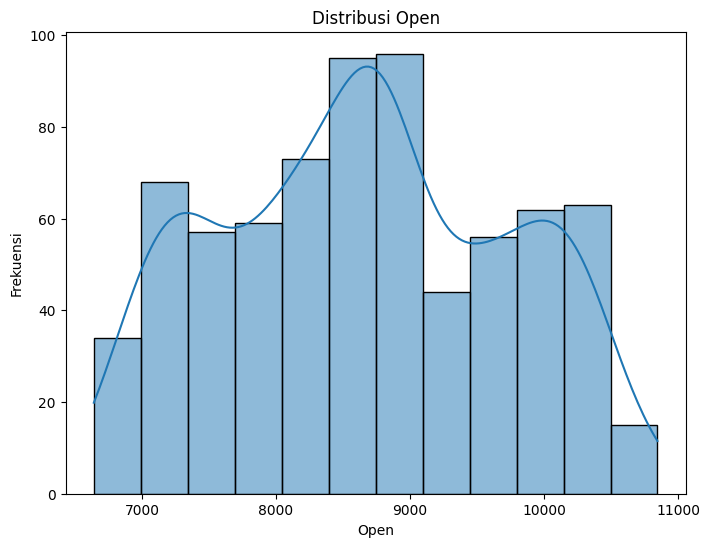

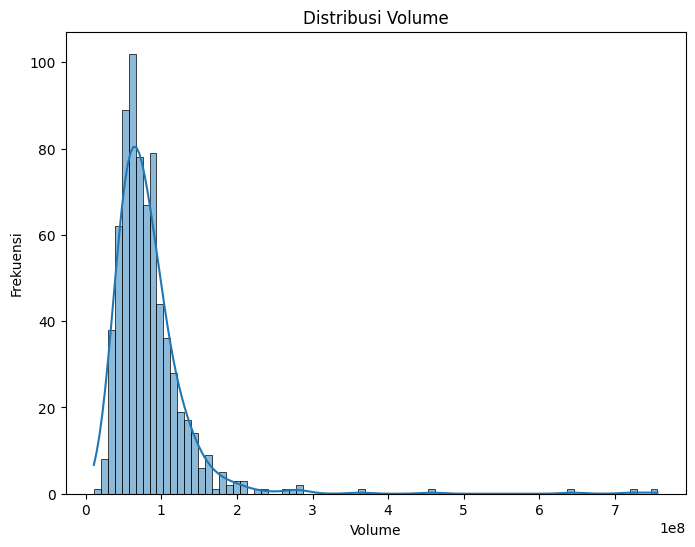

In [13]:
def visualisasi_distribusi(df):
  for kolom in df.select_dtypes(include=['number']):
    plt.figure(figsize=(8, 6))
    sns.histplot(df[kolom], kde=True)
    plt.title(f'Distribusi {kolom}')
    plt.xlabel(kolom)
    plt.ylabel('Frekuensi')
    plt.show()

#memanggil fungsi untuk visualisasi distribusi
visualisasi_distribusi(df)

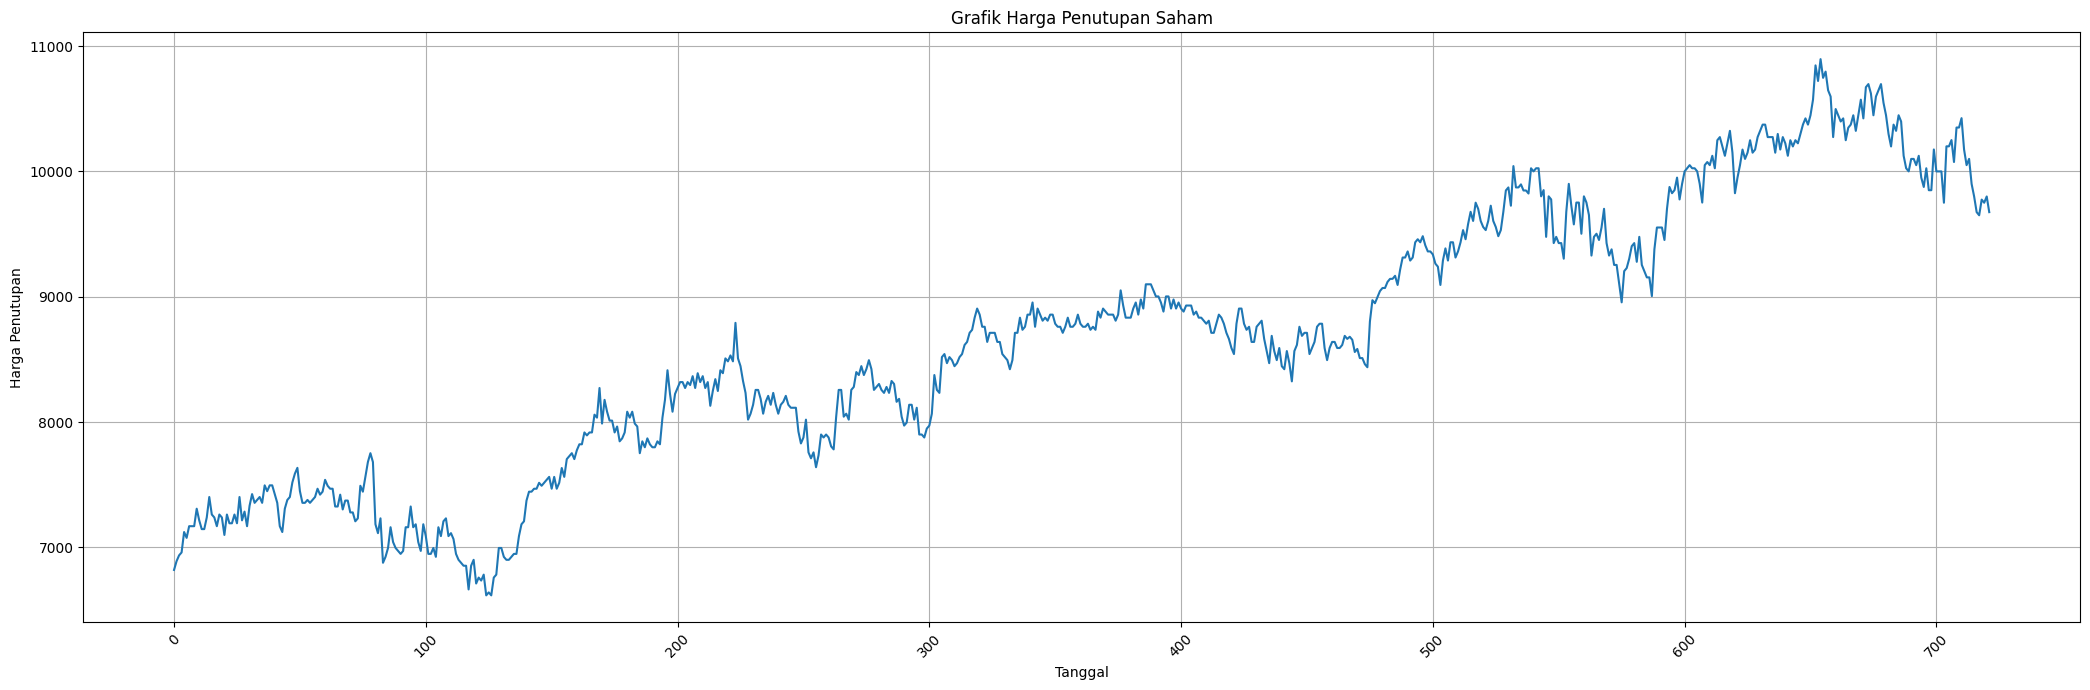

In [14]:
# Grafik Harga Penutupan Saham
plt.figure(figsize=(21, 7))
plt.plot(df['Close'])
plt.xlabel('Tanggal')
plt.ylabel('Harga Penutupan')
plt.title('Grafik Harga Penutupan Saham')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
# Untuk keperluan visualisasi candlestick, set index menjadi Date
df_indexed = df.copy()
df_indexed.set_index('Date', inplace=True)

In [16]:
data_df = df.drop(columns=['Date'])

In [19]:
#Normalisasi fitur
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_df.values)

In [20]:
# Membagi data menjadi set pelatihan dan pengujian
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [21]:
# Fungsi untuk membuat dataset dengan sliding window
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

In [22]:
look_back = 30  # Menggunakan 30 hari terakhir untuk prediksi
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

# Mengubah bentuk input menjadi [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [18]:
# # Gunakan lookback 30 hari agar model dapat menangkap konteks yang lebih panjang
# look_back = 30

In [ ]:
# # Pisahkan data: gunakan seluruh data kecuali 31 hari terakhir untuk training,
# # dan 31 hari terakhir sebagai validasi (proxy forecast Januari 2025)
# total_records = data_scaled_all.shape[0]
# if total_records <= (look_back + 31):
#     raise ValueError("Jumlah record data tidak mencukupi (harus > lookback + 31).")

# train_data_all = data_scaled_all[:total_records - 31]
# val_data_all = data_scaled_all[total_records - 31:]

In [ ]:
# #Fungsi untuk membuat dataset dengan sliding window (multivariat)
# def create_dataset_multivariate(data, look_back):
#   X, Y = [], []
#   for i in range(len(data) - look_back):
#     X.append(data[i:i+look_back])
#     Y.append(data[i+look_back])
#   return np.array(X), np.array(Y)

# X_train_all, Y_train_all = create_dataset_multivariate(train_data_all, look_back)
# print(f"X_train_all shape : {X_train_all.shape}")
# print(f"Y_train_all shape : {Y_train_all.shape}")
# print(f"Validation data shape : {val_data_all.shape}")

X_train_all shape : (661, 30, 5)
Y_train_all shape : (661, 5)
Validation data shape : (31, 5)


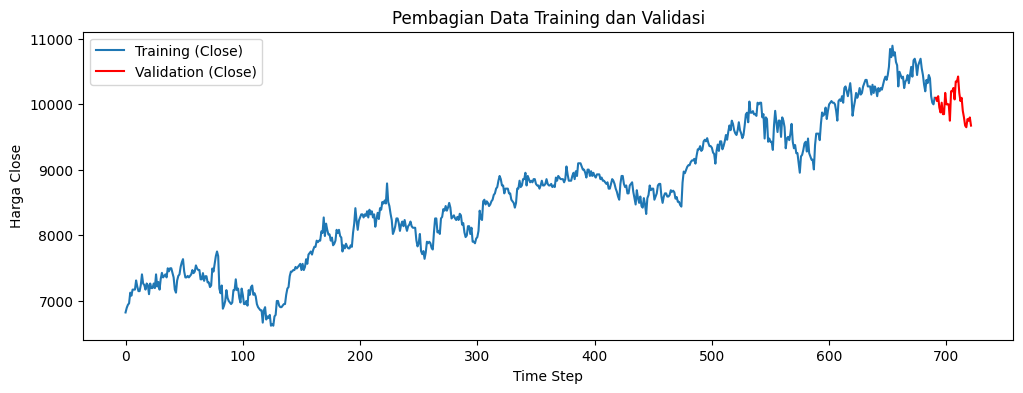

In [ ]:
# # Visualisasi pembagian data untuk kolom 'Close'
# idx_close = data_df.columns.get_loc("Close")
# train_close = scaler_all.inverse_transform(train_data_all)[:, idx_close]
# val_close = scaler_all.inverse_transform(val_data_all)[:, idx_close]

# plt.figure(figsize=(12, 4))
# plt.plot(range(len(train_close)), train_close, label="Training (Close)")
# plt.plot(range(len(train_close), len(train_close) + len(val_close)), val_close,
#          label="Validation (Close)", color='red')
# plt.xlabel("Time Step")
# plt.ylabel("Harga Close")
# plt.title("Pembagian Data Training dan Validasi")
# plt.legend()
# plt.show()


In [29]:
print(X_train.shape)  # Harusnya (jumlah_sample, 30, 1)

(547, 30, 1)


In [25]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.1 MB/s eta 0:00:00


In [28]:
import numpy as np
from deap import base, creator, tools, algorithms

# Definisikan fungsi fitness
def evaluate(individual):
    hidden_layers = individual[0]
    neurons = individual[1]
    learning_rate = individual[2]

    model = create_lstm_model(hidden_layers, neurons, learning_rate)  # Pastikan fungsi ini menerima parameter baru
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)  # Anda bisa menyesuaikan epochs dan batch_size
    predictions = model.predict(X_test)
    mse = np.mean((predictions - y_test.reshape(-1, 1)) ** 2)
    return (mse,)

# Inisialisasi DEAP
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("hidden_layers", np.random.choice, [10, 30, 50, 100, 150, 200])
toolbox.register("neurons", np.random.choice, [64, 128, 256, 512])
toolbox.register("learning_rate", np.random.choice, [0.1, 0.01, 0.001])
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.hidden_layers, toolbox.neurons, toolbox.learning_rate), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)  # Anda mungkin ingin menyesuaikan ini
toolbox.register("select", tools.selTournament, tournsize=3)

# Jalankan algoritma genetika
population = toolbox.population(n=10)
algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=10, verbose=True)

/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ValueError: Exception encountered when calling LSTM.call().

[1moutput_size must be an integer.[0m

Arguments received by LSTM.call():
  • args=('<KerasTensor shape=(None, 30, 1), dtype=float32, sparse=False, name=keras_tensor>',)
  • kwargs={'training': 'False', 'mask': 'None'}

# **2. Improved LSTM Baseline dengan MC Dropout (Model Awal)**

In [ ]:
# ==============================================================================
# 2. IMPROVED LSTM BASELINE DENGAN MC DROPOUT (MODEL AWAL)
# ==============================================================================

# Parameter training
epochs = 100
batch_size = 32


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 30, 128)             │          35,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 138,949 (542.77 KB)

 Trainable params: 138,949 (542.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0689
Epoch 1: val_loss improved from inf to 0.03545, saving model to improved_lstm_best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.0655 - val_loss: 0.0355 - learning_rate: 0.0010
Epoch 2/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0097
Epoch 2: val_loss improved from 0.03545 to 0.01090, saving model to improved_lstm_best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0096 - val_loss: 0.0109 - learning_rate: 0.0010
Epoch 3/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0075
Epoch 3: val_loss improved from 0.01090 to 0.00407, saving model to improved_lstm_best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0075 - val_loss: 0.0041 - learning_rate: 0.0010
Epoch 4/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0073
Epoch 4: val_loss did not improve from 0.00407
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0072 - val_loss: 0.0054 - learning_rate: 0.0010
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0047
Epoch 5: val_loss improved from 0.00407 to 0.00276, saving model to improved_lstm_best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0047 - val_loss: 0.0028 - learning_rate: 0.0010
Epoch 6/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0057 
Epoch 6: val_loss did not improve from 0.00276
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0056 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 7/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0064
Epoch 7: val_loss improved from 0.00276 to 0.00270, saving model to improved_lstm_best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0063 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 8/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0064
Epoch 8: val_loss did not improve from 0.00270
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0063 - val_loss: 0.0060 - learning_rate: 0.0010
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0045
Epoch 9: val_loss improved from 0.00270 to 0.00255, saving model to improved_lstm_best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0045 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 10/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0056
Epoch 10: val_loss did not improve from 0.00255
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0055 - val_loss: 0.0030 - learning_rate: 0.0010
Epoch 11/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0052
Epoch 11: val_loss did not improve from 0.00255
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0051 - val_loss: 0.0030 - learning_rate: 0.0010
Epoch 12/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0040
Epoch 12: val_loss did not improve from 0.00255
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0040 - val_loss: 0.0028 - learning_rate: 0.0010
Epoch 13/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0044
Epoch 13: val_loss did not improve from 0.00255
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0044 - val_loss: 0.0060 - learning_rate: 0.0010
Epoch 14/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 55m

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0047 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 15/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0041
Epoch 15: val_loss did not improve from 0.00200
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0041 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 16/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0035
Epoch 16: val_loss improved from 0.00200 to 0.00188, saving model to improved_lstm_best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0035 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 17/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0039
Epoch 17: val_loss did not improve from 0.00188
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0039 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 18/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0040
Epoch 18: val_loss did not improve from 0.00188
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0040 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 19/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0030
Epoch 19: val_loss did not improve from 0.00188
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0031 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 20/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0041
Epoch 20: val_loss improved from 0.00188 to 0.00179, saving model to improved_lstm_best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0041 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 21/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0034
Epoch 21: val_loss did not improve from 0.00179

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0034 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 22/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0036
Epoch 22: val_loss did not improve from 0.00179
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0036 - val_loss: 0.0023 - learning_rate: 5.0000e-04
Epoch 23/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0032
Epoch 23: val_loss did not improve from 0.00179
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0032 - val_loss: 0.0023 - learning_rate: 5.0000e-04
Epoch 24/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0031
Epoch 24: val_loss did not improve from 0.00179
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0031 - v

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0033 - val_loss: 0.0017 - learning_rate: 2.5000e-04
Epoch 29/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0037
Epoch 29: val_loss did not improve from 0.00173
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0036 - val_loss: 0.0019 - learning_rate: 2.5000e-04
Epoch 30/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0031
Epoch 30: val_loss improved from 0.00173 to 0.00170, saving model to improved_lstm_best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0031 - val_loss: 0.0017 - learning_rate: 2.5000e-04
Epoch 31/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0047
Epoch 31: val_loss improved from 0.00170 to 0.00166, saving model to improved_lstm_best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0045 - val_loss: 0.0017 - learning_rate: 2.5000e-04
Epoch 32/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0040
Epoch 32: val_loss did not improve from 0.00166
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0039 - val_loss: 0.0017 - learning_rate: 2.5000e-04
Epoch 33/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0038
Epoch 33: val_loss did not improve from 0.00166

Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0038 - val_loss: 0.0021 - learning_rate: 2.5000e-04
Epoch 34/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0033
Epoch 34: val_loss did not improve from 0.00166
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0033 - val_loss: 0.0018 - learning_rate: 1.2500e-04
Epoch 35/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0035
Epoch 35: val_loss did not improve from 0.00166
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0

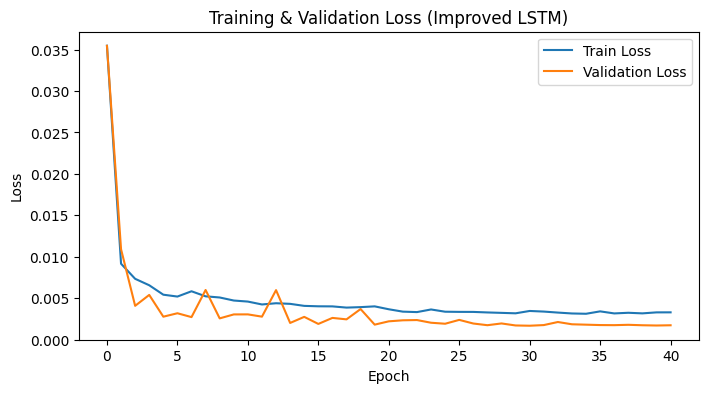

In [ ]:

# Membangun model LSTM yang lebih kompleks dengan Bidirectional LSTM, Dropout, dan Dense tambahan
improved_model = Sequential([
    Input(shape=(X_train_all.shape[1], X_train_all.shape[2])),
    Bidirectional(LSTM(units=64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(units=64)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(data_scaled_all.shape[1])
])

initial_lr = 0.001
optimizer = Adam(learning_rate=initial_lr)
improved_model.compile(loss='mean_squared_error', optimizer=optimizer)
improved_model.summary()

# Callback: EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ModelCheckpoint("improved_lstm_best_model.h5", monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)
]

history_improved = improved_model.fit(
    X_train_all, Y_train_all,
    validation_split=0.1,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)

plt.figure(figsize=(8, 4))
plt.plot(history_improved.history['loss'], label='Train Loss')
plt.plot(history_improved.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss (Improved LSTM)")
plt.legend()
plt.show()



In [ ]:
# Fungsi forecast rekursif dengan MC Dropout
def mc_forecast(model, initial_sequence, forecast_horizon, look_back, n_features, n_simulations=50):
    all_simulations = []
    for sim in range(n_simulations):
        current_sequence = initial_sequence.copy()
        sim_preds = []
        for _ in range(forecast_horizon):
            # Gunakan model(x, training=True) untuk mengaktifkan dropout saat inference
            pred = model(current_sequence.reshape(1, look_back, n_features), training=True)
            # Jika pred merupakan tensor, konversikan ke numpy
            if isinstance(pred, tf.Tensor):
                pred = pred.numpy()
            sim_preds.append(pred[0])
            current_sequence = np.concatenate((current_sequence[1:], pred), axis=0)
        all_simulations.append(sim_preds)
    all_simulations = np.array(all_simulations)
    median_forecast = np.median(all_simulations, axis=0)
    lower_forecast = np.percentile(all_simulations, 5, axis=0)
    upper_forecast = np.percentile(all_simulations, 95, axis=0)
    return median_forecast, lower_forecast, upper_forecast

forecast_horizon = 31
n_features = data_scaled_all.shape[1]

In [ ]:
# Gunakan lookback terakhir dari training sebagai initial sequence
initial_sequence_improved = train_data_all[-look_back:]
median_preds, lower_preds, upper_preds = mc_forecast(
    improved_model, initial_sequence_improved, forecast_horizon, look_back, n_features, n_simulations=50
)
median_preds_inv = scaler_all.inverse_transform(median_preds)
lower_preds_inv = scaler_all.inverse_transform(lower_preds)
upper_preds_inv = scaler_all.inverse_transform(upper_preds)




Improved LSTM (MC Forecast) - RMSE (Close): 545.3357
Improved LSTM (MC Forecast) - MAE (Close): 479.7263


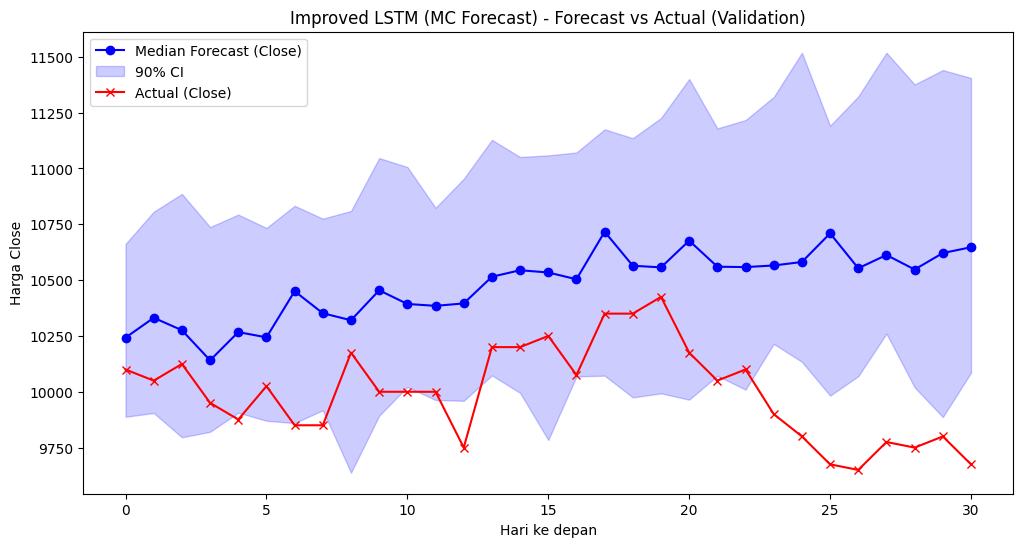

In [ ]:
# Evaluasi menggunakan median forecast (untuk kolom 'Close')
val_inv = scaler_all.inverse_transform(val_data_all)
improved_rmse = math.sqrt(mean_squared_error(val_inv[:, idx_close], median_preds_inv[:, idx_close]))
improved_mae = mean_absolute_error(val_inv[:, idx_close], median_preds_inv[:, idx_close])
print(f"\nImproved LSTM (MC Forecast) - RMSE (Close): {improved_rmse:.4f}")
print(f"Improved LSTM (MC Forecast) - MAE (Close): {improved_mae:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(range(forecast_horizon), median_preds_inv[:, idx_close], marker='o', color='blue', label="Median Forecast (Close)")
plt.fill_between(range(forecast_horizon),
                 lower_preds_inv[:, idx_close],
                 upper_preds_inv[:, idx_close], color='blue', alpha=0.2, label="90% CI")
plt.plot(range(forecast_horizon), val_inv[:, idx_close], marker='x', color='red', label="Actual (Close)")
plt.xlabel("Hari ke depan")
plt.ylabel("Harga Close")
plt.title("Improved LSTM (MC Forecast) - Forecast vs Actual (Validation)")
plt.legend()
plt.show()


# **3. Optimasi Hyperparameter dengan GA**

In [ ]:

# ==============================================================================
# 3. OPTIMASI HYPERPARAMETER DENGAN GENETIC ALGORITHM (GA)
# ==============================================================================

population_size = 20
generations = 10
mutation_rate = 0.1

def fitness(predictions, actual):
    rmse_val = math.sqrt(mean_squared_error(actual, predictions))
    return -rmse_val

def create_individual():
    return {
        'lstm_units1': random.randint(20, 80),
        'lstm_units2': random.randint(20, 80),
        'learning_rate': random.uniform(0.001, 0.005)
    }

population = [create_individual() for _ in range(population_size)]

def tournament_selection(population, fitnesses, tournament_size=3):
    selected = random.sample(list(zip(population, fitnesses)), tournament_size)
    selected.sort(key=lambda x: x[1], reverse=True)
    return selected[0][0]

def crossover(parent1, parent2):
    child = {}
    for key in parent1.keys():
        child[key] = parent1[key] if random.random() < 0.5 else parent2[key]
    return child

def mutate(individual, mutation_rate):
    if random.random() < mutation_rate:
        individual['lstm_units1'] = random.randint(20, 80)
    if random.random() < mutation_rate:
        individual['lstm_units2'] = random.randint(20, 80)
    if random.random() < mutation_rate:
        individual['learning_rate'] = random.uniform(0.001, 0.005)
    return individual

best_fitness_per_generation = []
last_generation_fitnesses = None

print("\n=== Mulai Optimasi GA ===")
for gen in range(generations):
    print(f"\nEvaluasi generasi {gen}...")
    fitnesses = []
    for idx, individual in enumerate(population):
        try:
            model_ga = Sequential([
                Input(shape=(X_train_all.shape[1], X_train_all.shape[2])),
                LSTM(units=individual['lstm_units1'], return_sequences=True),
                LSTM(units=individual['lstm_units2']),
                Dense(data_scaled_all.shape[1])
            ])
            opt = Adam(learning_rate=individual['learning_rate'])
            model_ga.compile(loss='mean_squared_error', optimizer=opt)

            model_ga.fit(X_train_all, Y_train_all, epochs=10, batch_size=32, verbose=0)

            current_sequence = train_data_all[-look_back:].copy()
            preds = []
            for _ in range(forecast_horizon):
                pred = model_ga.predict(current_sequence.reshape(1, look_back, n_features), verbose=0)
                preds.append(pred[0])
                current_sequence = np.concatenate((current_sequence[1:], pred), axis=0)
            preds = np.array(preds)
            preds_inv = scaler_all.inverse_transform(preds)

            val_inv = scaler_all.inverse_transform(val_data_all)
            fit_val = fitness(preds_inv[:, idx_close], val_inv[:, idx_close])
            if np.isnan(fit_val):
                fit_val = -np.inf
            fitnesses.append(fit_val)
            print(f"Individu {idx}: {individual}, fitness: {fit_val:.4f}")
        except Exception as e:
            print(f"Error pada individu {idx} dengan {individual}: {e}")
            fitnesses.append(-np.inf)
    best_fit = max(fitnesses)
    best_fitness_per_generation.append(best_fit)
    print(f"Generasi {gen} - Best fitness: {best_fit:.4f}")
    last_generation_fitnesses = fitnesses.copy()

    new_population = []
    while len(new_population) < population_size:
        parent1 = tournament_selection(population, fitnesses)
        parent2 = tournament_selection(population, fitnesses)
        child = crossover(parent1, parent2)
        child = mutate(child, mutation_rate)
        new_population.append(child)
    population = new_population



=== Mulai Optimasi GA ===

Evaluasi generasi 0...
Individu 0: {'lstm_units1': 51, 'lstm_units2': 23, 'learning_rate': 0.0024486550502483126}, fitness: -283.9031
Individu 1: {'lstm_units1': 20, 'lstm_units2': 59, 'learning_rate': 0.0047027036800861635}, fitness: -219.9754
Individu 2: {'lstm_units1': 76, 'lstm_units2': 31, 'learning_rate': 0.0016468199666023042}, fitness: -395.2040
Individu 3: {'lstm_units1': 27, 'lstm_units2': 43, 'learning_rate': 0.001329083381014903}, fitness: -347.6049
Individu 4: {'lstm_units1': 75, 'lstm_units2': 35, 'learning_rate': 0.0017449185034014527}, fitness: -467.5186
Individu 5: {'lstm_units1': 73, 'lstm_units2': 21, 'learning_rate': 0.00440580204209158}, fitness: -308.7120
Individu 6: {'lstm_units1': 41, 'lstm_units2': 54, 'learning_rate': 0.003572769260920122}, fitness: -284.5817
Individu 7: {'lstm_units1': 50, 'lstm_units2': 33, 'learning_rate': 0.004019819137293925}, fitness: -315.4012
Individu 8: {'lstm_units1': 48, 'lstm_units2': 44, 'learning_rate'

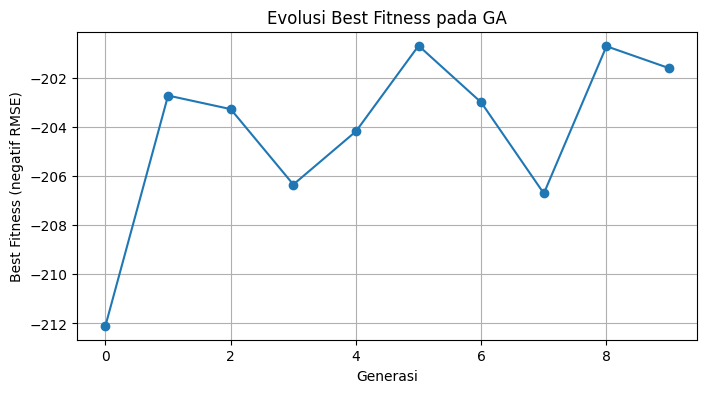


Hyperparameter terbaik hasil GA:
{'lstm_units1': 72, 'lstm_units2': 20, 'learning_rate': 0.0012727896069652301}


In [ ]:

plt.figure(figsize=(8, 4))
plt.plot(range(generations), best_fitness_per_generation, marker='o')
plt.xlabel("Generasi")
plt.ylabel("Best Fitness (negatif RMSE)")
plt.title("Evolusi Best Fitness pada GA")
plt.grid(True)
plt.show()

best_index = np.argmax(last_generation_fitnesses)
best_individual = population[best_index]
print("\nHyperparameter terbaik hasil GA:")
print(best_individual)

# **4. Model Final dgn Hyperparameter Terbaik**

In [ ]:

# ==============================================================================
# 4. MODEL FINAL DENGAN HYPERPARAMETER TERBAIK
# ==============================================================================

X_final, Y_final = create_dataset_multivariate(data_scaled_all, look_back)

final_model = Sequential([
    Input(shape=(X_final.shape[1], X_final.shape[2])),
    LSTM(units=best_individual['lstm_units1'], return_sequences=True),
    LSTM(units=best_individual['lstm_units2']),
    Dense(data_scaled_all.shape[1])
])
final_opt = Adam(learning_rate=best_individual['learning_rate'])
final_model.compile(loss='mean_squared_error', optimizer=final_opt)
final_model.summary()



Model: "sequential_201"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_402 (LSTM)                      │ (None, 30, 72)              │          22,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_403 (LSTM)                      │ (None, 20)                  │           7,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_202 (Dense)                    │ (None, 5)                   │             105 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,009 (117.22 KB)

 Trainable params: 30,009 (117.22 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("\nMelatih model final dengan seluruh data historis...")
history_final = final_model.fit(X_final, Y_final, epochs=20, batch_size=32, verbose=1)

initial_sequence_final = data_scaled_all[-look_back:].copy()
final_predictions = []
current_sequence = initial_sequence_final.copy()
for _ in range(forecast_horizon):
    pred = final_model.predict(current_sequence.reshape(1, look_back, n_features), verbose=0)
    final_predictions.append(pred[0])
    current_sequence = np.concatenate((current_sequence[1:], pred), axis=0)
final_predictions = np.array(final_predictions)
final_predictions_inv = scaler_all.inverse_transform(final_predictions)




Melatih model final dengan seluruh data historis...
Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.1283
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0053
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0040
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0026
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0026
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0034
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0027
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0031
Epoch 9/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0027
Epoch 10/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0027
Epoch 11/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0026
Epoch 12/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0028
Epoch 13/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0025
Epoch 14/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0027
Epoch 15/20
22/22 

In [ ]:
forecast_dates = pd.date_range(start="2025-01-01", periods=forecast_horizon, freq='D')
forecast_df = pd.DataFrame(final_predictions_inv, columns=data_df.columns, index=forecast_dates)
print("\nForecast Harga Saham (seluruh fitur) untuk Januari 2025:")
print(forecast_df)




Forecast Harga Saham (seluruh fitur) untuk Januari 2025:
                   Close          High           Low          Open      Volume
2025-01-01   9913.116211  10037.658203   9880.478516   9949.989258  66592752.0
2025-01-02   9908.059570  10025.727539   9871.909180   9944.984375  64377476.0
2025-01-03   9913.661133  10025.579102   9871.973633   9950.636719  62177732.0
2025-01-04   9926.710938  10033.577148   9879.102539   9963.572266  60130048.0
2025-01-05   9944.614258  10047.041016   9891.566406   9981.140625  58330172.0
2025-01-06   9965.470703  10064.025391   9907.744141  10001.447266  56828924.0
2025-01-07   9987.956055  10083.170898   9926.375977  10023.222656  55606116.0
2025-01-08  10011.157227  10103.491211   9946.435547  10045.583008  54633376.0
2025-01-09  10034.372070  10124.266602   9967.249023  10067.887695  53866188.0
2025-01-10  10057.283203  10145.174805   9988.240234  10089.984375  53291160.0
2025-01-11  10079.664062  10165.915039  10009.118164  10111.605469  52840

In [ ]:
final_rmse = math.sqrt(mean_squared_error(val_inv[:, idx_close], final_predictions_inv[:, idx_close]))
final_mae = mean_absolute_error(val_inv[:, idx_close], final_predictions_inv[:, idx_close])
print(f"\nFinal Model - RMSE (Close): {final_rmse:.4f}")
print(f"Final Model - MAE (Close): {final_mae:.4f}")




Final Model - RMSE (Close): 333.7699
Final Model - MAE (Close): 250.2629


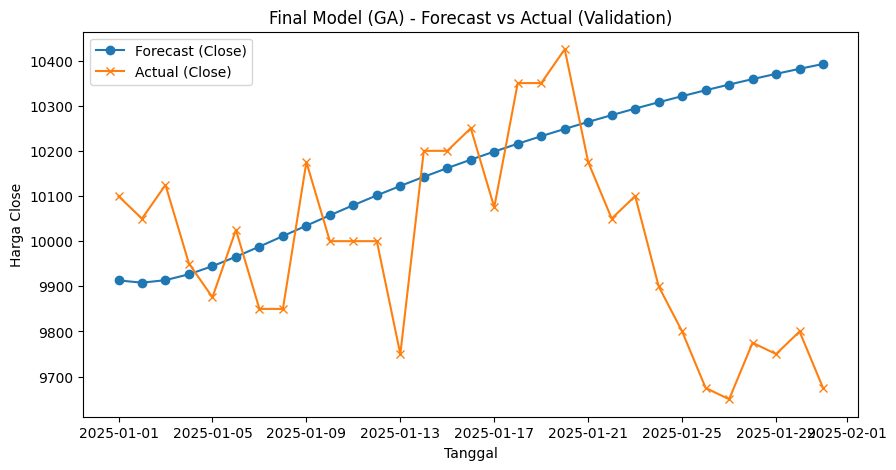

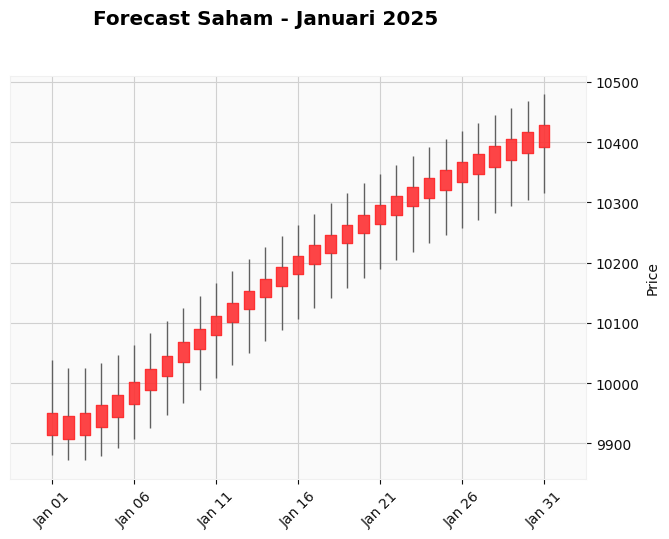

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(forecast_df.index, final_predictions_inv[:, idx_close], marker='o', label="Forecast (Close)")
plt.plot(forecast_df.index, val_inv[:, idx_close], marker='x', label="Actual (Close)")
plt.xlabel("Tanggal")
plt.ylabel("Harga Close")
plt.title("Final Model (GA) - Forecast vs Actual (Validation)")
plt.legend()
plt.show()

if set(["Open", "High", "Low", "Close"]).issubset(forecast_df.columns):
    mpf.plot(forecast_df, type='candle', style='yahoo', title="Forecast Saham - Januari 2025")